In [1]:
import os

import numpy as np
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt

from src import constants as Con

from src.predictive_modeling.answer_correctness.answer_correctness_data import (
    build_trial_level_full_features_for_correctness,

)
from src.predictive_modeling.answer_correctness.answer_correctness_models import (
    MajorityBaselineCorrectness,
    AreaMetricsCorrectnessLogRegModel,
    DerivedFeaturesCorrectnessLogRegModel,
    FullFeaturesCorrectnessLogRegModel,
)
from src.predictive_modeling.answer_correctness.answer_correctness_eval import (
    evaluate_models_on_answer_correctness,
    evaluate_models_on_answer_correctness_leave_one_trial_out
)
from src.predictive_modeling.answer_correctness.answer_correctness_viz import (
    plot_coef_summary_barh,
    show_correctness_model_results,
    plot_top_abs_coef_feature_frequency_across_participants,
)
from src.predictive_modeling.common.viz_utils import plot_confusion_heatmap


In [2]:
hunters = pd.read_csv("../data/hunters.csv")
gatherers = pd.read_csv("../data/gatherers.csv")

In [3]:
correctness_models = [
    MajorityBaselineCorrectness(),
    AreaMetricsCorrectnessLogRegModel(),
    DerivedFeaturesCorrectnessLogRegModel(),
    FullFeaturesCorrectnessLogRegModel(),
]

In [4]:
pref_specs = [
    (Con.MEAN_DWELL_TIME, "high"),
    (Con.MEAN_FIXATIONS_COUNT, "high"),
    (Con.MEAN_FIRST_FIXATION_DURATION, "high"),
    (Con.SKIP_RATE, "low"),
    (Con.AREA_DWELL_PROPORTION, "high"),
    (Con.MEAN_AVG_FIX_PUPIL_SIZE, "high"),
    (Con.MEAN_MAX_FIX_PUPIL_SIZE, "high"),
    (Con.MEAN_MIN_FIX_PUPIL_SIZE, "low"),
    (Con.FIRST_ENCOUNTER_AVG_PUPIL_SIZE, "high"),
]

In [5]:
all_participants = pd.concat([hunters, gatherers], ignore_index=True)

In [6]:
results_all_corr_full = evaluate_models_on_answer_correctness(
    df=all_participants,
    models=correctness_models,
    group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID),
    split_group_cols=[Con.PARTICIPANT_ID, Con.TRIAL_ID],
    builder_fn=lambda d, group_cols: build_trial_level_full_features_for_correctness(
        d,
        group_cols=group_cols,
        pref_specs=pref_specs,
    ),
)

show_correctness_model_results(results_all_corr_full)


KeyboardInterrupt



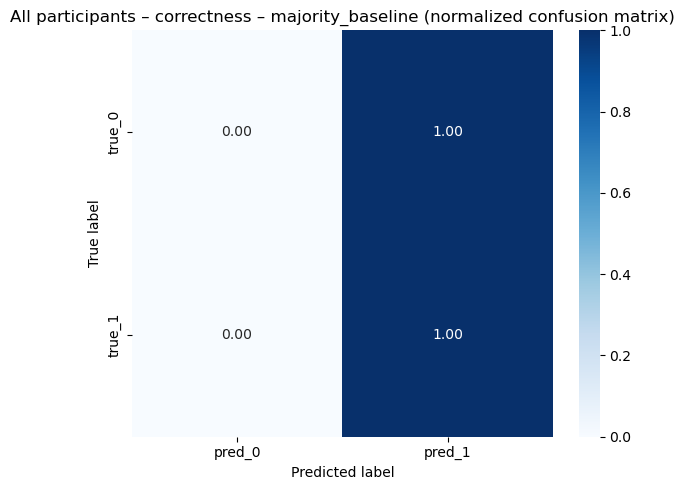

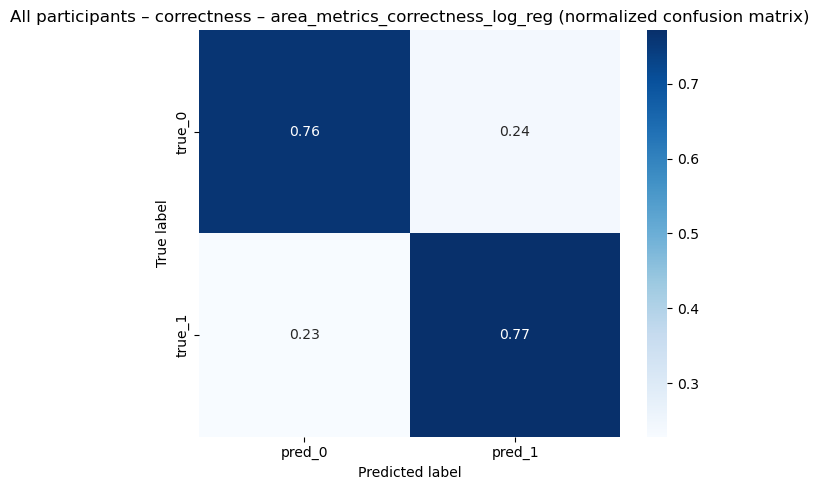

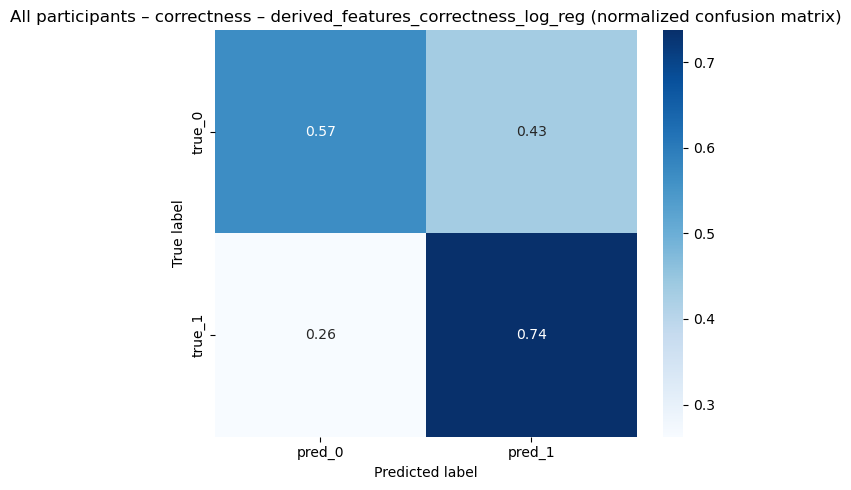

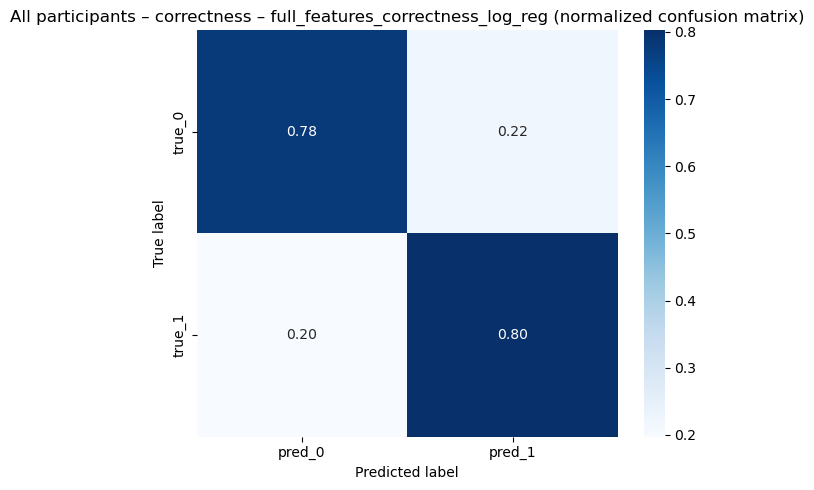

In [7]:
for name, res in results_all_corr_full.items():
    plot_confusion_heatmap(
        y_true=res.y_true,
        y_pred=res.y_pred,
        labels=(0, 1),
        include_minus1=False,
        normalize=True,
        title=f"All participants – correctness – {name} (normalized confusion matrix)",
    )

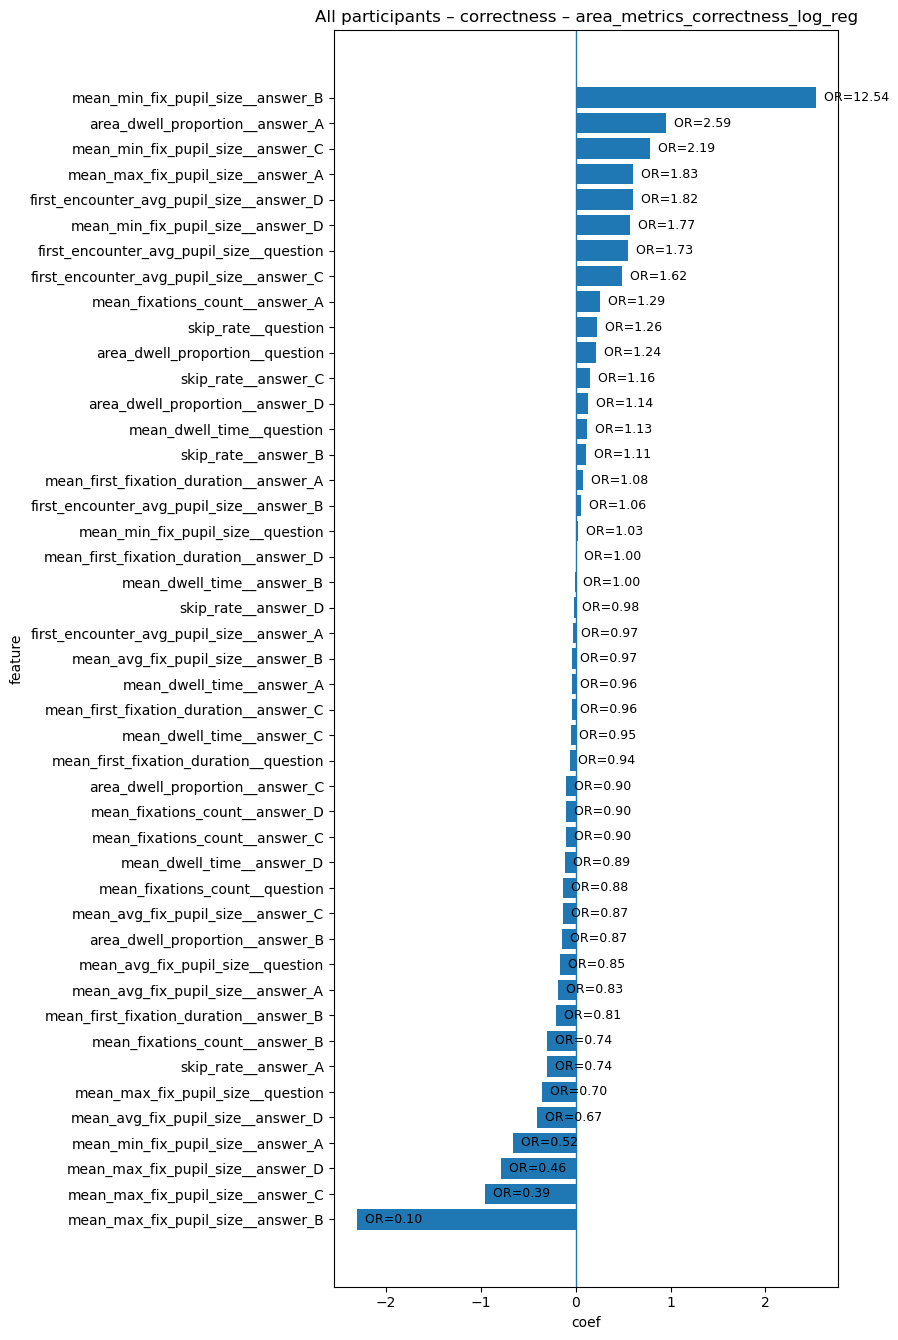

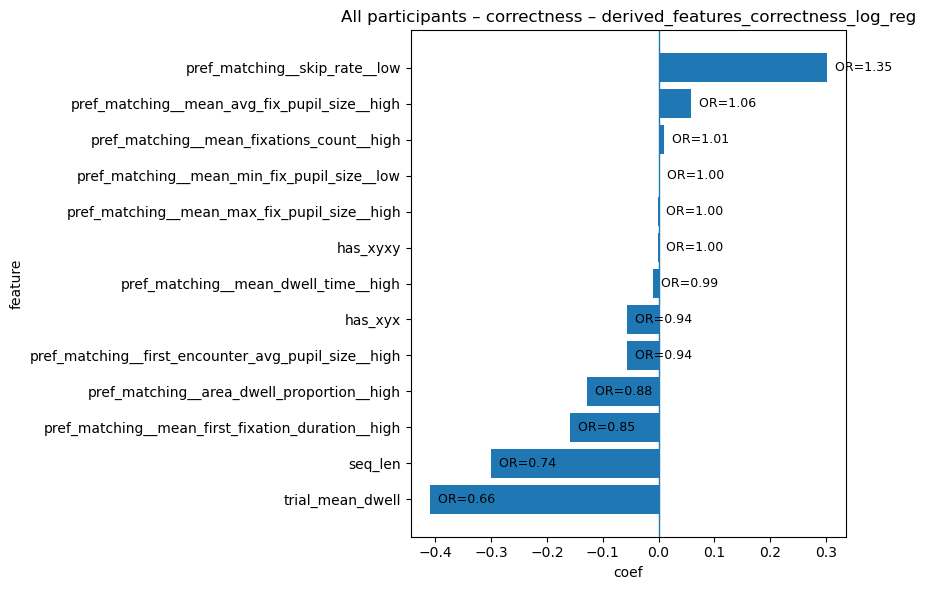

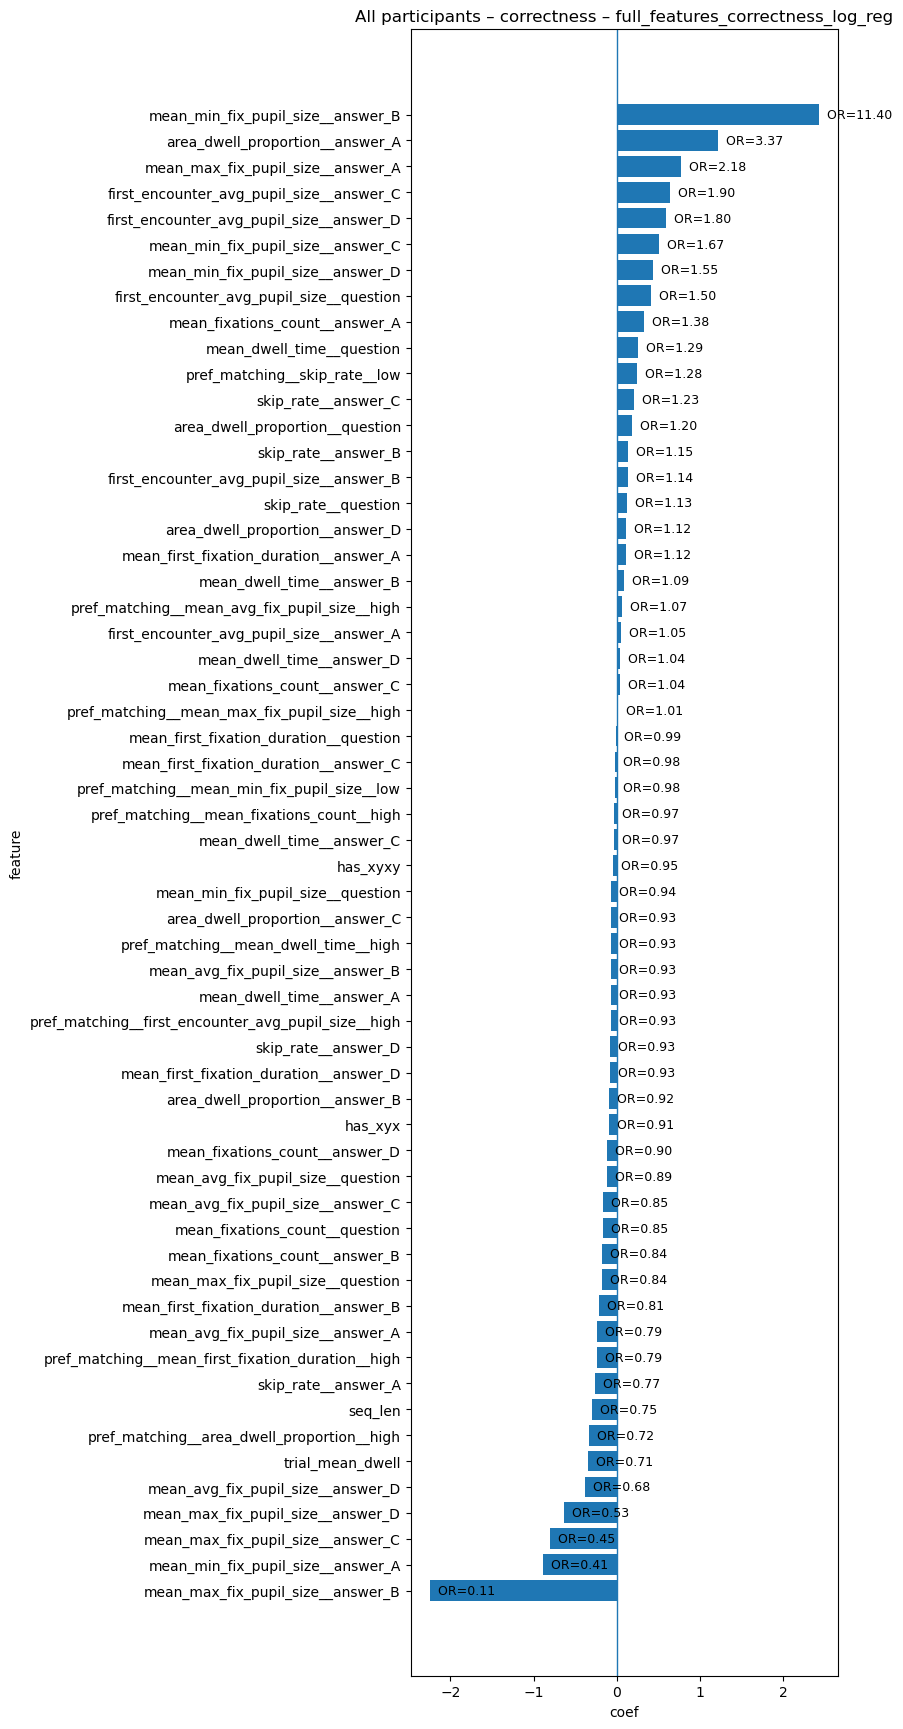

In [8]:
for model_name, res in results_all_corr_full.items():
    if res.coef_summary is None or res.coef_summary.empty:
        continue

    plot_coef_summary_barh(
        coef_summary=res.coef_summary,
        value_col ="coef",
        model_name=model_name,
        title=f"All participants – correctness – {model_name}",
        save=True,
    )


In [6]:
results_by_pid = evaluate_models_on_answer_correctness_leave_one_trial_out(
    df=all_participants,
    models=correctness_models,
    group_cols=(Con.PARTICIPANT_ID, Con.TRIAL_ID),
    builder_fn=lambda d, group_cols: build_trial_level_full_features_for_correctness(
        d,
        group_cols=group_cols,
        pref_specs=pref_specs,
    ),
)

In [16]:
base_out = "../reports/plots/participent_correctness_coeffs"

for pid, per_model in results_by_pid.items():
    for model_name, res in per_model.items():
        if res.coef_summary is None or res.coef_summary.empty:
            continue

        save_path = os.path.join(base_out, model_name, f"{pid}.png")

        fig, _ = plot_coef_summary_barh(
            coef_summary=res.coef_summary,
            value_col="coef",
            model_name=model_name,
            title=f"Participant {pid} – correctness – {model_name}",
            save=True,
            save_path=save_path,
        )

        plt.close(fig)

,feature,count,n_pos,n_neg,n_zero,total_occ,prop,sign_varies,majority_sign,minority_count
14,mean_dwell_time__answer_D,1,0,1,0,1,0.002809,False,-1,0
8,first_encounter_avg_pupil_size__answer_D,1,1,0,0,1,0.002809,False,1,0
11,mean_dwell_time__answer_A,1,0,1,0,1,0.002809,False,-1,0
19,mean_first_fixation_duration__question,1,0,1,0,1,0.002809,False,-1,0
40,trial_mean_dwell,2,0,2,0,2,0.005618,False,-1,0
24,mean_fixations_count__question,2,0,2,0,2,0.005618,False,-1,0
22,mean_fixations_count__answer_C,2,0,2,0,2,0.005618,False,-1,0
6,first_encounter_avg_pupil_size__answer_B,2,2,0,0,2,0.005618,False,1,0
39,skip_rate__question,3,3,0,0,3,0.008427,False,1,0
20,mean_fixations_count__answer_A,3,3,0,0,3,0.008427,False,1,0


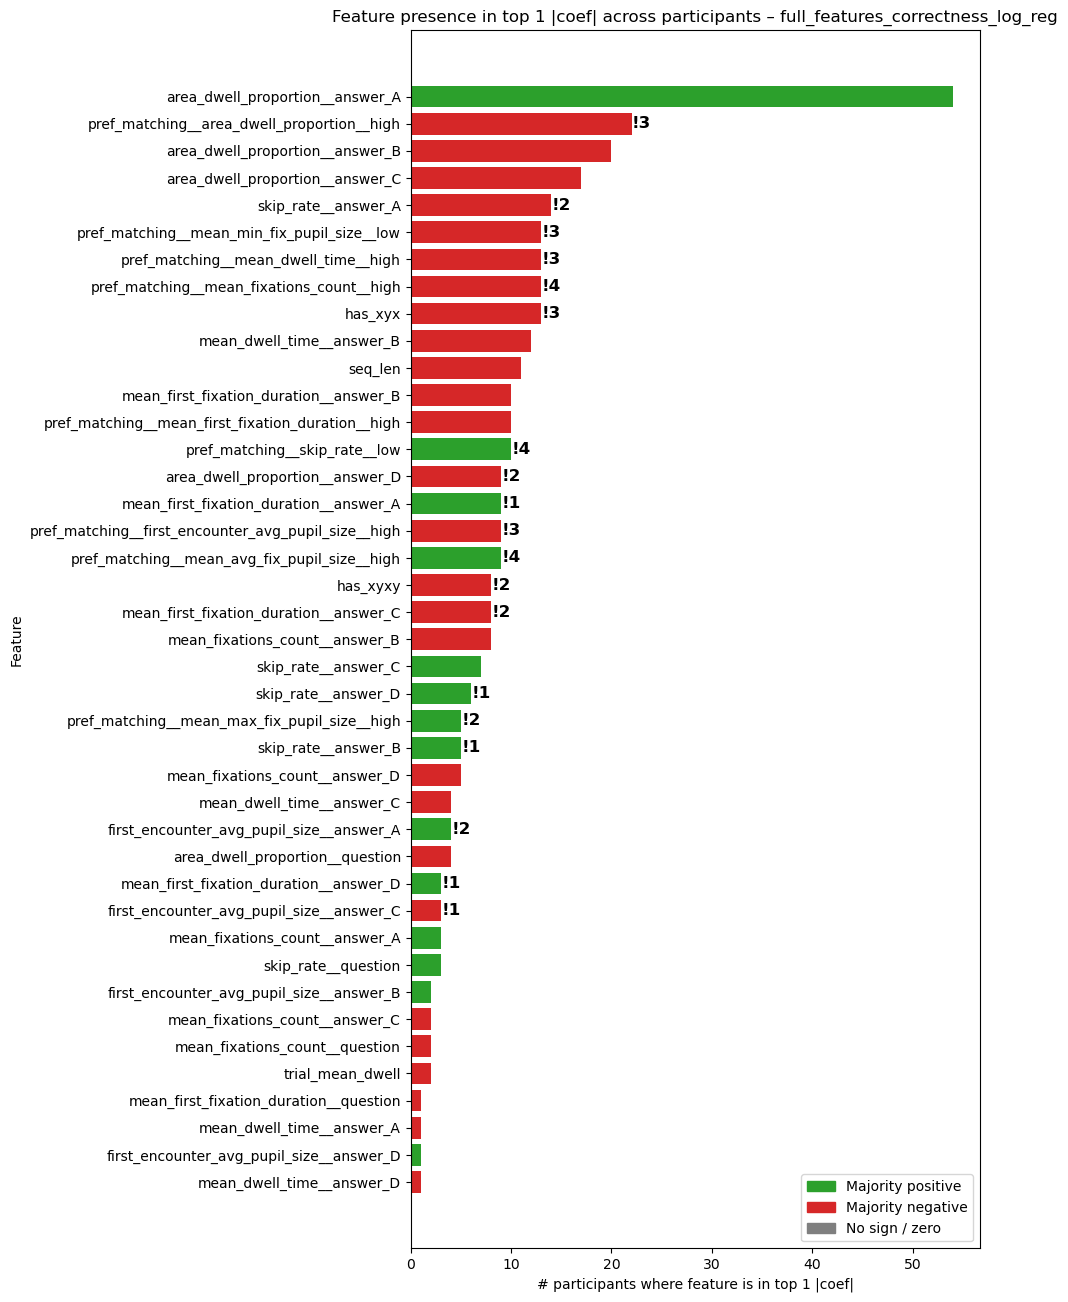

In [12]:
i = 1

fig, summary_df = plot_top_abs_coef_feature_frequency_across_participants(
    results_by_pid=results_by_pid,
    model_name="full_features_correctness_log_reg",
    coef_col="coef",
    top_k_within_participant=i,
    top_k_features=70,
    save_path=f"../reports/plots/participent_correctness_coeffs/top{i}_presence_full_features.png",
)

summary_df